<a href="https://colab.research.google.com/github/chainer-community/chainer-colab-notebook/blob/master/hands_on_ja/chainer/begginers_hands_on/01_Chainer_basic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 Chainerの基本的な使い方を学んでみよう

このNotebookの目的は以下の通りです。

* 畳み込みニューラルネットワークについて学習すること
* Chainerの機能について学習すること


## ColaboratoryでChainerを使うための設定

### 必要なライブラリ・Chainer・CuPyのインストール

下記のスクリプト内では、GPUを動かすのに必要なパッケージのインストール、Chainerのインストール、cudaのバージョンに応じたCuPyのインストールが行われています。

本来なら適切なバージョンの**CuPyをインストールする必要があります。**しかし、上記スクリプトはColaboratoryにインストールされているcudaのバージョンを見て、自動的に適切なCuPyをインストールします。

In [0]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0    279      0  0:00:05  0:00:05 --:--:--   381
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


Chainer v4.0.0から`chainer.print_runtime_info()`という便利なメソッドが追加されました。以下のコマンドをターミナルで実行し、ChainerやCuPyが正しくインストールされたかを確認してみましょう。

In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3


うまくインストールできていますね。以下のチュートリアルでは、pydotをネットワーク構造の可視化に使いますので、これも同時にインストールしておきましょう。

In [0]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

最後に以前使用した関数をchutilというパッケージにまとめましたので、ここでインストールしましょう。

In [3]:
!pip install chutil

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer
import chutil

## 畳み込みニューラルネットワーク (前回の復習)



[LeNet5](http://yann.lecun.com/exdb/lenet/)をシンプルにしたモデルを以下に示します。このモデルは、3つの畳み込み(convolution)層と、2つの全結合層を持つ計5層のネットワークです。

- これを元に以下の条件で精度90%以上を達成しましょう。

    1. エポック数30以下
    2. 訓練時間200秒以内

![LeNet-5 architecture as published in [1]](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)
LeNet-5 architecture as published in [1]

```python
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1, pad=0)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1, pad=0)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        return self.fc5(h)
```



そもそも、ここでは初めて紹介することになる層があると思います。まずはこれらについて説明します。

* 畳み込み層 (`L.Convolution2D`)
* プーリング層 (`F.max_pooling_2d`)

### 2次元畳み込み層 (`L.Convolution2D`)
畳み込み層とは、入力データに対して[畳み込み](https://ja.wikipedia.org/wiki/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF)演算を行う層のことです。今回は画像に適用するということで、特に2次元の場合について説明します。

畳み込み層に使用される主なパラメータとして、以下が存在します。

* フィルターサイズ  `ksize`：フィルターの長さのこと
* ストライド `stride`：フィルターの適用間隔のこと
* パッディングサイズ `pad`：周辺を0で埋める長さのこと

言葉で説明するよりは画像を利用したほうが直感的に理解できると思うので、
例えば以下の場合についてgif画像[2]を利用して説明します。

1. フィルターサイズ  `ksize=3`、ストライド `stride=1`、パッディングサイズ `pad=0`
2. フィルターサイズ  `ksize=3`、ストライド `stride=2`、パッディングサイズ `pad=0`
3. フィルターサイズ  `ksize=3`、ストライド `stride=1`、パッディングサイズ `pad=1`




1についてですが、フィルターサイズ  `ksize=3`とあるように、平行移動しているフィルターの長さが3になっています。

![no padding no strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

2についてですが、1に対してストライド `stride=2`と変化しています。そのため、フィルターの長さに変化はありませんが、入力データに対して2個おきにフィルターを適用しています。

![no padding strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)

3についてですが、1に対してパッディングサイズ `pad=1`と変化しています。そのため、フィルターの長さに変化はありませんが、周囲を1つ穴埋めした入力データに対してフィルターを適用しています。

![same padding no strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

おそらくお気づきになったと思いますが、上記のパラメータによって入力データと出力データのサイズが変化します。入力データのサイズを$L_i$、出力データのサイズを$L_o$とした時以下の関係があります。

$$
L_o = (L_i + 2 * pad - ksize) / stride + 1
$$

そもそもなぜこのような畳み込み処理を画像に適用するのでしょうか。

実は画像処理では、古くから畳み込み処理により平滑化やエッジ抽出を行ってきました。
例えば、ラプラシアンフィルタは以下のようにエッジ抽出の効果があります。

![laplacian filter](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/laplacian_filter.png)

もし、フィルターサイズ ksize=3のフィルタが以下だった場合、

$$
\begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

畳み込み層も同様の役割を持つでしょう。


WikipediaのKernel_(image_processing)の項目には、他のフィルターも紹介されていますので御覧ください。

#### 課題
- 上記のパラメータ以外にも、`dilate`というパラメータがあります。以下のように、飛び飛びにフィルターを適用します。この時、入力データのサイズ𝐿𝑖 と出力データのサイズ𝐿𝑜の間で、どのような等式が成り立つでしょうか。

![no padding no strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

### プーリング層 (`F.max_pooling_2d`)
プーリング層は、ダウンサンプルを行う層です。こちらも画像の場合なので、特に2次元の場合を説明します。

プーリング層も、畳み込み層と同様のパラメータを持ちます。

* フィルターサイズ  `ksize`：フィルターの長さのこと
* ストライド `stride`：フィルターの適用間隔のこと
* パッディングサイズ `pad`：周辺を0で埋める長さのこと


`F.max_pooling_2d`の場合、フィルター適用範囲の最大値を結果として出力します。

![max pooling](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/max_pooling.png)

他のプーリング層は[Reference](https://docs.chainer.org/en/stable/reference/functions.html#spatial-pooling)を参照ください。

### 前回の課題に挑戦
前回の繰り返しにはなりますが、データセットのダウンロードと、訓練のための関数`train_and_validate`を定義します。

In [5]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device=0):
    
    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

それでは、`LeNet5`にいくつかの変更を加えた`MyConvNet`を定義して、訓練とテストを行ってみましょう。変更点はコメントにあるように以下の通りです。

* 各convolution層のチャネル数、ノード数を増やす
* 各convolution層のフィルター数`ksize=3`, ストライド`stride=3`、パッディング`pad=1`に変更
* convolution層を1層(`conv4`)追加
* 活性化関数を`ReLU`に変更

ちなみに、`L.Convolution2D`の`in_channels`や`L.Linear`の第一引数を`None`にすることで明示的にサイズを指定していませんが、実はこれでもちゃんと動きます。なぜかというと、最初の`forward`呼び出し時に、入力されたサイズで動的にメモリを確保してくれるからです。Chainerの良さの1つですね。


In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class MyConvNet(Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            # all pads are 0 -> 1
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)  # 6 -> 32
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1) # 16 -> 64
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # 120 -> 128
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # new layer
            self.fc5 = L.Linear(None, 1000) # 84 -> 1000
            self.fc6 = L.Linear(None, 10)

    def forward(self, x):
        h = F.relu(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv2(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv3(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv4(h))  # sigmoid -> relu
        h = F.relu(self.fc5(h))  # sigmoid -> relu
        return self.fc6(h)

ここで、このようなモデルにしたのには理由があります。画像の分野で有名なモデルは多くありますが、その中の1つに[VGG16](https://docs.chainer.org/en/stable/examples/cnn.html#vgg16)があります。今回は以下のような点を倣ってみました。

* chennelを32 -> 64 -> 128というようにだんだんと増やしていく。
* `ksize=3, stride=1, pad=1`にする



特に、`ksize=3, stride=1, pad=1`にする理由は明確にあり、これを上記等式に代入すると、

$$
L_o = (L_i + 2 * pad - ksize) / stride + 1
$$

以下が成立します。こうすることによって、入力データと出力データのサイズが等しくなり、取扱いが楽になります。

$$
L_o = L_i
$$

では、上記変更を加えたモデル`MyConvNet`を訓練してみましょう。




In [8]:
n_epoch = 20
batchsize = 128

model = MyConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.462895    0.828844       0.32198        0.880637           15.911        
2           0.280492    0.896899       0.297068       0.896855           22.9795       
3           0.235661    0.91248        0.260569       0.9018             30.0246       
4           0.201747    0.925292       0.245985       0.907041           37.1026       
5           0.17745     0.933184       0.239446       0.913469           44.1548       
6           0.153617    0.941667       0.227212       0.920095           51.1913       
7           0.133692    0.949568       0.23591        0.921578           58.3275       
8           0.111639    0.957993       0.271392       0.916139           65.3611       
9           0.0975162   0.964055       0.278673       0.917919           72.4358       
10          0.082586    0.96913        0.29724        0.918612           79.5206       
11          0.0751227   0.971074  

検証用データでも90%の精度を達成しています。これならテスト用データでも目標を達成してそうですね。

以下の関数を実行して確かめてみましょう。

In [9]:
from chutil.visualize.show import show_test_performance

show_test_performance(classifier_model, test)

Test accuracy: 0.91396487


達成できていましたね！パチパチ！

と終わりにしたいところですが、もう少し細かく結果を見てみましょう。

まずは、`show_graph`を使ってネットワーク構造を表示してみましょう。
実際にどのようなネットワークができたか確認できますね。

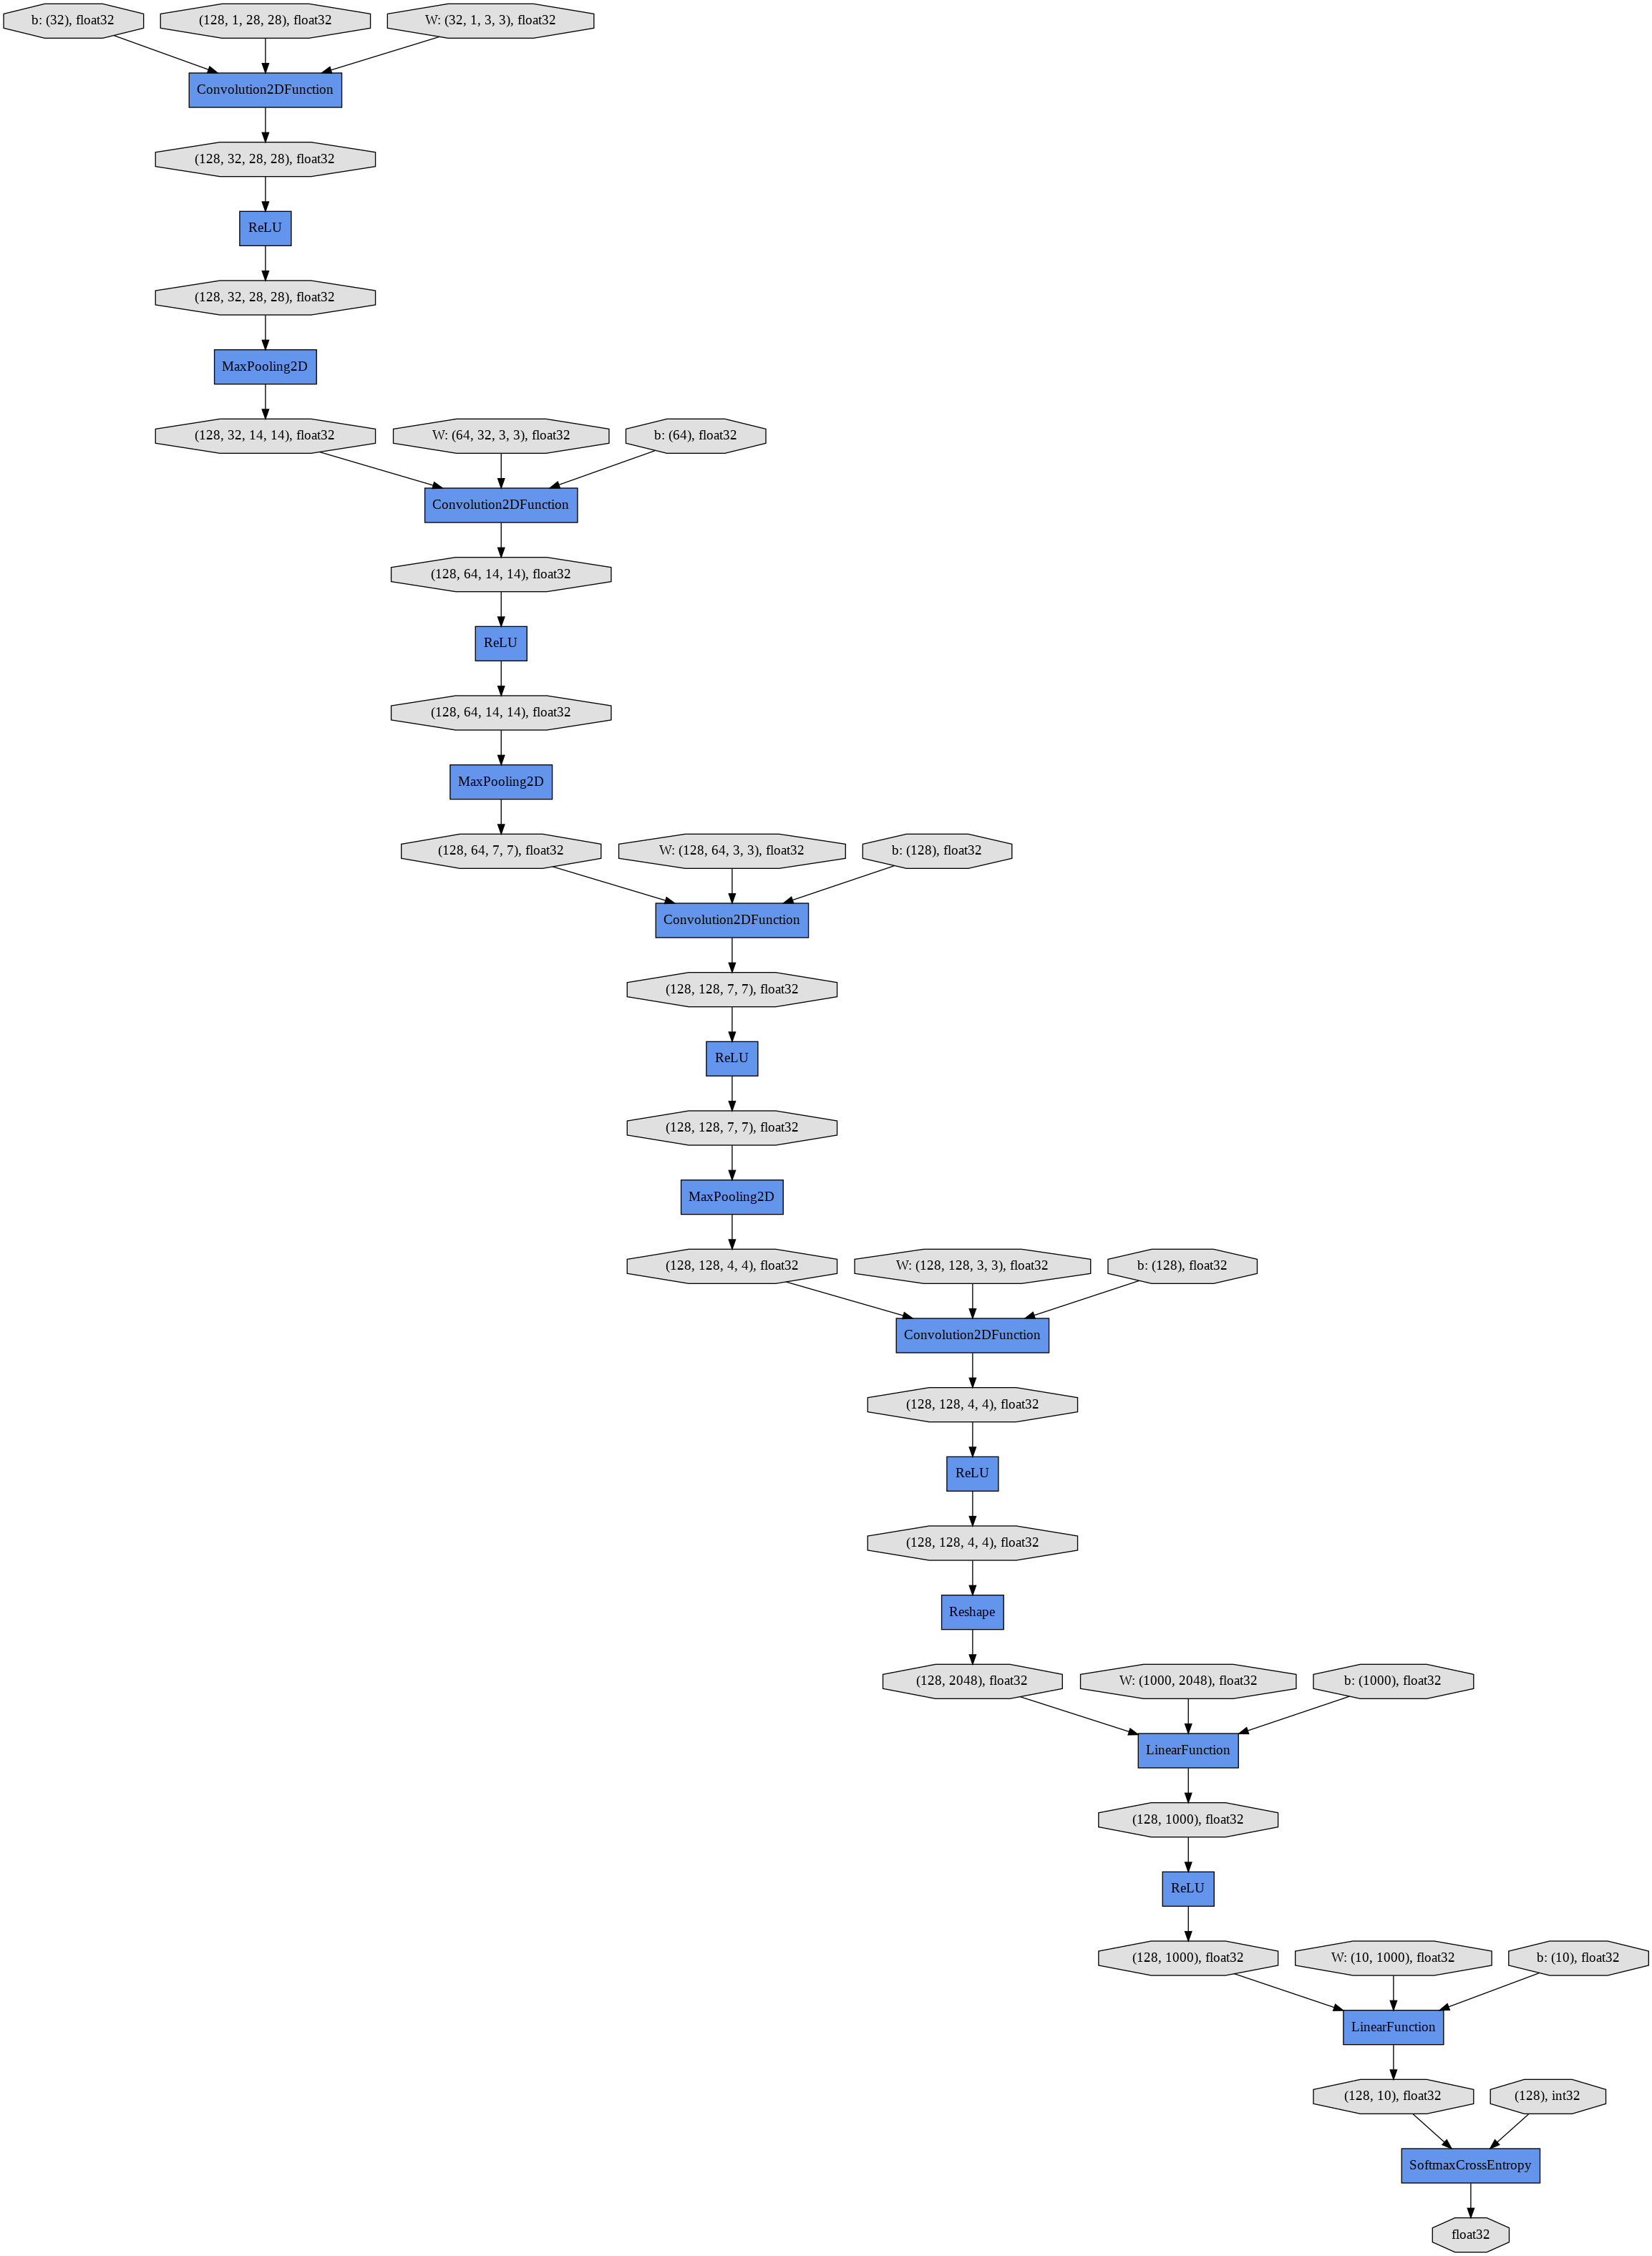

In [10]:
from chutil.visualize.show import show_graph

show_graph()

次に、`show_loss_and_accuracy`を使って、訓練用データと検証用データの損失と精度をplotしてみましょう。
おそらく以下のことに気づくと思います。

* 訓練用データでは、`epoch`数に伴い、損失は減少・精度は増加し、共に改善している
* しかし、検証用データでは、`epoch=5`程度で精度は頭打ちになっており、損失も最小値になったあと悪化している

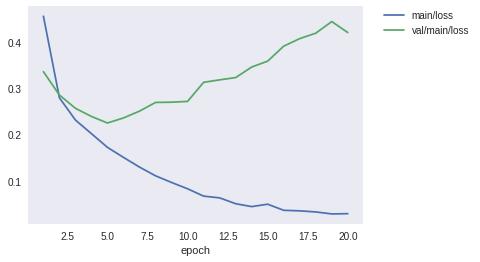

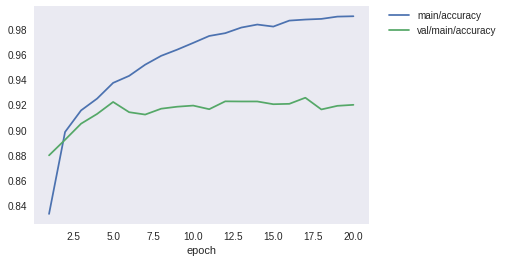

In [0]:
from chutil.visualize.show import show_loss_and_accuracy

show_loss_and_accuracy()

訓練用データでは精度が順調に伸びるのに、検証用データでは伸びない・・・。このような現象をどこかで聞いたことがあるような気がしますよね。

## 過学習と汎化性能

### 過学習とは

上記のように、訓練用データに対して精度が高いが、未知データ（訓練には使用していないデータ）に対しては精度が低い、という現象を**過学習**と呼びます。

過学習が起きてしまう原因は様々にありますが、概して以下が挙げられると思います。

1. 訓練用データと、未知のデータの性質が異なる
2. 訓練用データに対して学習をしすぎ、結果に対して偽陽性な関連性について学習をしてしまっている

前回、試験問題の例えを使って、簡単に過学習について説明しましたが、その例えをここでも使うと以下のように言えます。

1. 練習問題を解いてきたが、試験では全く違う分野の問題が出てきてしまい解けなかった
2. 練習問題を解きすぎて答えを丸暗記してしまい、試験ではその覚えた答えを使ってそのまま解答したら微妙な違いがあって不正解だった

ちなみに、機械学習において過学習が起きてしまう場合、以下のようなことをしている場合が多いです。

* 解きたい問題に対して、データ数が少なすぎる
* 解きたい問題に対して、モデルが複雑すぎる

また、Deep Learningの場合、**適切なepoch数で訓練を切り上げること**をしないと、多くの場合過学習を引き起こしてしまいます。例えば、さきほど訓練したモデルで、検証用データの精度・損失のグラフを見ると、5epoch目あたりの精度が最も高そうです。

このように、Deep Learningは訓練をし続けると最終的には過学習してしまいます。しかし、以下の場合は性能を改善するために、過学習を防ぐ手法を試してみる価値はあります。

* 検証用データの精度・損失を見ると、少ないepoch数で既に過学習が始まっている
* 検証用データの精度・損失が想定に達していない

#### 課題
scikit-learnの [Underfitting vs Overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) は、「Overfitting (過学習)」と「Underfitting (過学習の対義語)」を説明したwebページです。これを実行してみて、モデルが複雑すぎるとなぜ過学習してしまうのか、体験してみてください。

![Underfitting vs Overfitting](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)

### 汎化性能とは

そもそも過学習というのは、どのような状況を意味しているのでしょうか。ここでは違う観点から説明を行いたいと思います。

度々説明していますが、**汎化性能**とは未知データに対する予測性能のことを言います。この性能を最大化するのが、私たちのゴールです。あらゆる関数の中から最も汎化性能の高い関数を選べたとして、その関数を以下の図で$f^*$とします。

また、ある訓練結果の予測関数を$f$とします。例えば、私たちが今回作り出した学習結果が該当します。

#### 誤差の種類

実は最終的なゴールである$f^*$と、私たちが作り出した関数$f$の間には大きく分けて3つの誤差が存在します。

ここで、$F$はあるモデルが表現できる範囲を意味し、例えば今回の話で言うと上記のNNが表現できる関数の範囲になります。それなので、$f^*_F$は、そのモデルで表現できる範囲で最も汎化性能の高い関数となります。

また、$f^*_F$を求めようにも与えられたデータに限りがある場合は正しく求められません。有限のデータを与えられた時に求められる関数を$\hat{f}_F$と表現します。

この時、それぞれの誤差を以下のように言います。

1. 近似誤差
    * モデルの表現力を反映する誤差
2. 推定誤差
    * 訓練用データが実際に使用するときのデータと異なることによって生まれる誤差
    * 過学習の原因
3. 最適化誤差
    * 数値計算誤差などによって生まれる、訓練用データの最適な関数との誤差


![generalization error](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/generalization_error.png)

cited from [3]

### Dropout
ここで、NNで汎化性能の改善に効くと言われているDropoutという手法を使ってみましょう。Dropoutは学習時、推論時に以下を行います。

* 学習時：一定の確率$p$で入力を0にし(無視する)、その分残りを$\frac{1}{1-p}$倍にして出力する
* 推論時：何もしない

![dropout](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/dropout.png)

同時に複数のモデルを学習し、その結果をアンサンブル学習したような効果が生まれ、結果として汎化性能が改善されることがあります。

#### 課題
* 下記コードにDropoutを追加して効果を確かめてみましょう。Dropoutの追加やパラメータの変更をすることで精度93%以上を達成しましょう。

```
h = F.dropout(F.relu(self.fc5(h)))  # add dropout
```

Droopoutの追加は上記のようにすることでできます。



In [0]:
class MyConvNet(Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.fc5 = L.Linear(None, 1000)
            self.fc6 = L.Linear(None, 10)

    def forward(self, x):
        h = F.relu(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv4(h))
        h = F.relu(self.fc5(h))
        return self.fc6(h)

In [0]:
n_epoch = 30
batchsize = 128

model = MyConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.560679    0.790761       0.374753       0.870748           9.76857       
2           0.348739    0.871284       0.308418       0.887164           19.1579       
3           0.304647    0.887179       0.288652       0.898438           28.5293       
4           0.274207    0.899536       0.26459        0.904866           37.9636       
5           0.256863    0.904352       0.247794       0.908129           47.3874       
6           0.242957    0.909996       0.244631       0.911986           56.7753       
7           0.230465    0.915261       0.223468       0.917029           66.2931       
8           0.219386    0.918129       0.234875       0.910107           75.6793       
9           0.211985    0.920217       0.219008       0.920589           85.0968       
10          0.207442    0.922614       0.222533       0.917919           94.5544       
11          0.200679    0.925461  

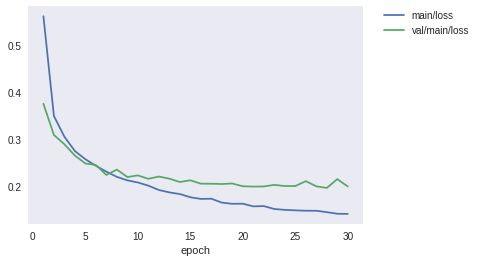

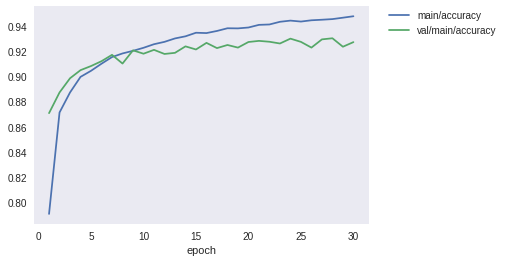

In [0]:
show_loss_and_accuracy()

In [0]:
show_test_performance(classifier_model, test)

ちなみに下記のようなモデルを動かしてみると93%前後の性能が実現できました。

```
class MyConvNet(Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.fc5 = L.Linear(None, 2000) # 1000 -> 2000
            self.fc6 = L.Linear(None, 10)

    def __call__(self, x):
        h = F.dropout(F.relu(self.conv1(x.reshape((-1, 1, 28, 28)))), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv2(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv3(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv4(h)))  # add dropout
        h = F.dropout(F.relu(self.fc5(h)))  # add dropout
        return self.fc6(h)
 ```

#### 課題
他にも汎化性能の向上に効く手法として**Nomalization(正則化)**という手法があります。

Chainerには多くのメジャーな正則化手法が揃っています。それぞれどのような正則化をしているか調べ、実際に使ってみてください。

* [Batch Normalization](https://docs.chainer.org/en/stable/reference/generated/chainer.links.BatchNormalization.html)

## Chainerの機能

前回、今回のハンズオンでは、下記の関数`train_and_validate`を使用してきました。
ここでは、その関数の中身について解説していきます。

```python
def  train_and_validate(
        model, optimizer, train, validation, n_epoch, enable_cupy, batchsize):
    
    # 1. cpu/gpuを決める
    device = -1
    if enable_cupy:
        device = 0
        chainer.backends.cuda.get_device_from_id(device).use()
        model.to_gpu()
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()
```

### 2. Iteratorの作成

データセットの準備は完了しましたが、このままネットワークの学習に使うのは少し面倒です。なぜなら、ネットワークのパラメータ最適化手法として広く用いられているStochastic Gradient Descent (SGD)という手法では、一般的にいくつかのデータを束ねた**ミニバッチ**と呼ばれる単位でネットワークにデータを渡し、それに対する予測を作って、ラベルと比較するということを行います。そのため、**バッチサイズ分だけデータとラベルを束ねる作業が必要です。**

そこで、**データセットから決まった数のデータとラベルを取得し、それらを束ねてミニバッチを作ってくれる機能を持った`Iterator`を使いましょう。**`Iterator`は、先程作ったデータセットオブジェクトを渡して初期化してやったあとは、`next()`メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（`epoch`）などの情報がどうように記録されているおり、学習ループを書いていく際に便利です。

データセットオブジェクトからイテレータを作るには、以下のようにします。

ここでは、学習に用いるデータセット用のイテレータ（`train_iter`）と、検証用のデータセット用のイテレータ（`valid_iter`）、および学習したネットワークの評価に用いるテストデータセット用のイテレータ（`test_iter`）の計3つを作成しています。ここで、`batchsize = 128`としているので、作成した3つの`Iterator`は、例えば`train_iter.next()`などとすると128枚の数字画像データを一括りにして返してくれます。

#### NOTE: `SerialIterator`について

Chainerがいくつか用意している`Iterator`の一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルな`Iterator`です。コンストラクタの引数にデータセットオブジェクトと、バッチサイズを取ります。このとき、渡したデータセットオブジェクトから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。これは、主にvalidation用のデータセットに対して使うフラグです。デフォルトでは、`True`になっています。また、`shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。`SerialIterator`の他にも、マルチプロセスで高速にデータを処理できるようにした`MultiprocessIterator`や`MultithreadIterator`など、複数の`Iterator`が用意されています。詳しくは以下を見てください。

- [Chainerで使えるIterator一覧](https://docs.chainer.org/en/stable/reference/iterators.html)

### 3. 最適化手法の選択

では、上で定義したネットワークをMNISTデータセットを使って訓練してみましょう。学習時に用いる最適化の手法としてはいろいろな種類のものが提案されていますが、Chainerは多くの手法を同一のインターフェースで利用できるよう、`Optimizer`という機能でそれらを提供しています。`chainer.optimizers`モジュール以下に色々なものを見つけることができます。一覧はこちらにあります：

- [Chainerで使える最適化手法一覧](https://docs.chainer.org/en/stable/reference/optimizers.html)

ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。`Optimizer`のオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることで`Optimizer`に、何を最適化すればいいか把握させることができます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下の`chainer.optimizers.SGD`のうち`SGD`の部分を`MomentumSGD`, `RMSprop`,  `Adam`などに変えるだけで、最適化手法の違いがどのような学習曲線（ロスカーブ）の違いを生むかなどを簡単に調べることができます。

#### NOTE

今回はSGDのコンストラクタの`lr`という引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要な**ハイパーパラメータ**として知られています。

### 2. Updaterの準備

ここからが学習ループを自分で書く場合と異なる部分です。ループを自分で書く場合には、データセットからバッチサイズ分のデータをとってきてミニバッチに束ねて、それをネットワークに入力して予測を作り、それを正解と比較し、ロスを計算してバックワード（誤差逆伝播）をして、`Optimizer`によってパラメータを更新する、というところまでを、以下のように書いていました。

```python
# ---------- 学習の1イテレーション ----------
train_batch = train_iter.next()
x, t = concat_examples(train_batch, gpu_id)

# 予測値の計算
y = net(x)

# ロスの計算
loss = F.softmax_cross_entropy(y, t)

# 勾配の計算
net.cleargrads()
loss.backward()

# パラメータの更新
optimizer.update()
```

これらの処理を、まるっと`Updater`はまとめてくれます。これを行うために、**`Updater`には`Iterator`と`Optimizer`を渡してやります。** `Iterator`はデータセットオブジェクトを持っていて、そこからミニバッチを作り、`Optimizer`は最適化対象のネットワークを持っていて、それを使って前進計算とロスの計算・パラメータのアップデートをすることができます。そのため、この2つを渡しておけば、上記の処理を`Updater`内で全部行ってもらえるというわけです。では、`Updater`オブジェクトを作成してみましょう。

#### NOTE

ここでは、ネットワークを`L.Classifier`で包んでいます。`L.Classifier`は一種の`Chain`になっていて、渡されたネットワーク自体を`predictor`というattributeに持ち、**ロス計算を行う機能を追加してくれます。**こうすると、`net()`はデータ`x`だけでなくラベル`t`も取るようになり、まず渡されたデータを`predictor`に通して予測を作り、それを`t`と比較して**ロスの`Variable`を返すようになります。**ロス関数として何を用いるかはデフォルトでは`F.softmax_cross_entropy`となっていますが、`L.Classifier`の引数`lossfunc`にロス計算を行う関数を渡してやれば変更することができるため、Classifierという名前ながら回帰問題などのロス計算機能の追加にも使うことができます。（`L.Classifier(net, lossfun=L.mean_squared_error, compute_accuracy=False)`のようにする）

`StandardUpdater`は前述のような`Updater`の担当する処理を遂行するための最もシンプルなクラスです。この他にも複数のGPUを用いるための`ParallelUpdater`などが用意されています。

### 3. Trainerの準備

実際に学習ループ部分を隠蔽しているのは`Updater`なので、これがあればもう学習を始められそうですが、`Trainer`はさらに`Updater`を受け取って学習全体の管理を行う機能を提供しています。例えば、**データセットを何周したら学習を終了するか(stop_trigger)** や、**途中のロスの値をどのファイルに保存したいか**、**ロスカーブを可視化した画像ファイルを保存するかどうか**など、学習全体の設定として必須・もしくはあると便利な色々な機能を提供しています。

必須なものとしては学習終了のタイミングを指定する`stop_trigger`がありますが、これは`Trainer`オブジェクトを作成するときのコンストラクタで指定します。指定の方法は単純で、`(長さ, 単位)`という形のタプルを与えればよいだけです。「長さ」には数字を、「単位」には`'iteration'`もしくは`'epoch'`のいずれかの文字列を指定します。こうすると、たとえば100 epoch（データセット100周）で学習を終了してください、とか、1000 iteration（1000回更新）で学習を終了してください、といったことが指定できます。`Trainer`を作るときに、`stop_trigger`を指定しないと、学習は自動的には止まりません。

では、実際に`Trainer`オブジェクトを作ってみましょう。

`out`引数では、この次に説明する`Extension`を使って、ログファイルやロスの変化の過程を描画したグラフの画像ファイルなどを保存するディレクトリを指定しています。

Trainerと、その内側にあるいろいろなオブジェクトの関係は、図にまとめると以下のようになっています。このイメージを持っておくと自分で部分的に改造したりする際に便利だと思います。

![image](https://qiita-image-store.s3.amazonaws.com/0/17934/a751df31-b999-f692-d839-488c26b1c48a.png)

### 4. TrainerにExtensionを追加する

`Trainer`を使う利点として、

- ログを自動的にファイルに保存（`LogReport`)
- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot`）
- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
- ネットワークの構造をGraphvizのdot形式で保存（`dump_graph`）
- ネットワークのパラメータの平均や分散などの統計情報を出力（`ParameterStatistics`）

などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、`Trainer`オブジェクトに対して`extend`メソッドを使って追加したい`Extension`のオブジェクトを渡してやるだけです。では実際に幾つかの`Extension`を追加してみましょう。

#### `LogReport`

`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

#### `snapshot`

`Trainer`の`out`引数で指定した出力ディレクトリに`Trainer`オブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。`Trainer`オブジェクトは上述のように`Updater`を持っており、この中に`Optimizer`とモデルが保持されているため、この`Extension`でスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。

#### `dump_graph`

指定された`Variable`オブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先は`Trainer`の`out`引数で指定した出力ディレクトリです。

#### `Evaluator`

評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。内部では、`chainer.config.using_config('train', False)`が自動的に行われます。`backprop_enable`を`False`にすることは行われないため、メモリ使用効率はデフォルトでは最適ではありませんが、基本的には`Evaluator`を使えば評価を行うという点において問題はありません。

#### `PrintReport`

`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

#### `PlotReport`

引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

#### `ParameterStatistics`

指定したレイヤ（Link）が持つパラメータの平均・分散・最小値・最大値などなどの統計情報を計算して、ログに保存します。パラメータが発散していないかなどをチェックするのに便利です。

---

これらの`Extension`は、ここで紹介した以外にも、例えば`trigger`によって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください

- [ChainerのTrainer extension一覧](http://docs.chainer.org/en/stable/reference/extensions.html)

## 次回の準備
次回のハンズオンでは自分で用意したデータセットでの学習を予定しています。その予習として下記のようなkaggleのデータセットを用意してみました。下記課題ではkaggleからデータセットのdownload、結果の提出部分を用意していますので、ぜひ自分のモデルで学習させてみてsubmitしてみてください。

#### 課題
次回の準備として、kaggleのデータセットを利用して何かしらの結果を提出してみましょう。手順は[リンク](https://qiita.com/fam_taro/items/eb9bae0b82248f9abd28)を参考にしています。


In [0]:
!pip install kaggle

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions list -s digit

ref               deadline             category            reward  teamCount  userHasEntered  
----------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer  2030-01-01 00:00:00  Getting Started  Knowledge       2586            True  


In [0]:
!kaggle competitions download -c digit-recognizer

 86% 63.0M/73.2M [00:00<00:00, 67.3MB/s]
100% 73.2M/73.2M [00:00<00:00, 107MB/s] 
 84% 41.0M/48.8M [00:00<00:00, 81.8MB/s]
100% 48.8M/48.8M [00:00<00:00, 140MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 52.8MB/s]


In [0]:
!ls /content/

adc.json     sample_submission.csv  test1.zip  train.csv
sample_data  sampleSubmission.csv   test.csv   train.zip


!kaggle competitions submit -c <competition-name> -f <submit.csv> -m "My submission message"

In [0]:
!kaggle competitions submit -c digit-recognizer -f /content/sample_submission.csv -m "Test"

100% 235k/235k [00:00<00:00, 912kB/s]
Successfully submitted to Digit Recognizer

## Reference
* [1] [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
* [2] [Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
* [3] [最適化から見たディープラーニングの考え方](http://www.orsj.or.jp/archive2/or60-4/or60_4_191.pdf)